# What factors explain the returns of the stocks in the Russell 1000 Index?

We analyze whether changes in various fundamental and technical variables can predict one-month stock returns in the U.S.
We choose use twelve fundamental and technical variables and calculate their 12-month changes using published data as of 12/31/2015 and 12/31/2014 from Bloomberg. Note that if a company's fiscal year end is 12/31/2015, it would not have announced its financial results yet. In this case, we will use the latest data available, i.e. the September quarterly data (9/30/2015). 
We conclude that when we evaluate U.S. stocks, it is the most important to look at the changes in Book to Market, Operating Profit Margin, Earnings Yield, and Price Volatility of each stock.

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
from patsy import dmatrices, dmatrix
import statsmodels.api as sm

%matplotlib inline

DATA_DIR = '../data/'
# Load the first dataset from 12/31/2015 
df15_dec = pd.read_csv(DATA_DIR + '20151231stocks_v2.csv')
# Load the second dataset from 12/31/2014
df14_dec = pd.read_csv(DATA_DIR + '20141231stocks_v2.csv')
df15_dec.rename(columns=lambda x: x+'15',inplace=True)
df14_dec.rename(columns=lambda x: x+'14',inplace=True)
frames = [df14_dec, df15_dec]
df_all = pd.concat((frames), axis = 1)
df_all.rename(columns={'Ticker14': 'Ticker','Country14': 'Country', 'Name14':'Name','Sector14':'Sector'}, inplace=True)

In [45]:
#Here is a glimpse of the dataset. Each row represents a stock.
df_all.head()

,Ticker,Name,Country,Sector,LastPrice14,LastPrice+1M14,T12M_DVDS_PAID14,TRAIL_12M_EARN_FOR_COMMON14,TOTAL_EQUITY14,BS_TOT_ASSET14,...,TRAIL_12M_FREE_CASH_FLOW15,TRAIL_12M_OPER_MARGIN15,TRAIL_12M_GROSS_MARGIN15,TRAIL_12M_NET_SALES15,TRAIL_12M_ACCT_RCV_UNBILLED_REV15,VOLATILITY_90D15,CUR_MKT_CAP15,TRAIL_12M_EBITDA15,TRAIL_12M_INT_EXP15,NET_DEBT15
0,VRSK UW Equity,Verisk Analytics Inc,US,Industrials,64.05,64.35,0.0,389.895,725.984,2677.7,...,481.27,37.6132,61.3786,1897.208,8.666,29.034,13025.6511,898.97,106.515,3025.91
1,AA UN Equity,Alcoa Inc,US,Materials,15.79,15.65,-138.0,-2231.000,15135.000,37122.0,...,924.00,7.0185,21.2457,23666.000,256.000,47.548,12930.9711,2956.00,491.000,7538.00
2,AXP UN Equity,American Express Co,US,Financials,93.04,80.69,-1262.0,5700.000,20216.000,153862.0,...,14892.00,24.7865,NaN,35136.000,NaN,20.921,68454.3031,12130.00,1628.000,31875.00
3,EPE UN Equity,EP Energy Corp,US,Energy,10.44,10.35,0.0,150.000,3713.000,9026.0,...,-372.00,45.9849,51.8874,2914.000,47.000,104.110,1089.7436,2310.00,332.000,4903.00
4,VZ UN Equity,Verizon Communications Inc,US,Telecommunication Services,46.78,45.71,-7169.0,16923.000,17968.000,226293.0,...,18793.00,16.2227,59.9772,130558.000,NaN,18.333,188063.3122,37226.00,5024.000,108143.00


In [46]:
#After combining data from 2014 and 2015, there are 42 columns.
df_all.info()
#The 12 x variables we use are price momentum, 12-month changes in ROE, ROA, Dividend yield, earnings yeld, book to market ratio, OCF yield, FCF yield, leverage ratio, sales to market ratio, and price volatility. Before we did the analysis, we spent quite a bit of time to clean the dataset. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033 entries, 0 to 1032
Data columns (total 42 columns):
Ticker                               1033 non-null object
Name                                 1033 non-null object
Country                              1033 non-null object
Sector                               1033 non-null object
LastPrice14                          992 non-null float64
LastPrice+1M14                       994 non-null float64
T12M_DVDS_PAID14                     974 non-null float64
TRAIL_12M_EARN_FOR_COMMON14          983 non-null float64
TOTAL_EQUITY14                       1001 non-null float64
BS_TOT_ASSET14                       1001 non-null float64
TRAIL_12M_CASH_FROM_OPER14           975 non-null float64
TRAIL_12M_FREE_CASH_FLOW14           974 non-null float64
TRAIL_12M_OPER_MARGIN14              981 non-null float64
TRAIL_12M_GROSS_MARGIN14             736 non-null float64
TRAIL_12M_NET_SALES14                983 non-null float64
TRAIL_12M_ACCT_RCV_UN

In [47]:
#We looked at the missing values.
is_null = lambda col: sum(pd.isnull(df_all[col]))
missing_values = [(col,is_null(col)) for col in df_all if is_null(col)]
missing_values

[('LastPrice14', 41),
 ('LastPrice+1M14', 39),
 ('T12M_DVDS_PAID14', 59),
 ('TRAIL_12M_EARN_FOR_COMMON14', 50),
 ('TOTAL_EQUITY14', 32),
 ('BS_TOT_ASSET14', 32),
 ('TRAIL_12M_CASH_FROM_OPER14', 58),
 ('TRAIL_12M_FREE_CASH_FLOW14', 59),
 ('TRAIL_12M_OPER_MARGIN14', 52),
 ('TRAIL_12M_GROSS_MARGIN14', 297),
 ('TRAIL_12M_NET_SALES14', 50),
 ('TRAIL_12M_ACCT_RCV_UNBILLED_REV14', 383),
 ('VOLATILITY_90D14', 57),
 ('CUR_MKT_CAP14', 39),
 ('TRAIL_12M_EBITDA14', 138),
 ('TRAIL_12M_INT_EXP14', 264),
 ('NET_DEBT14', 32),
 ('T12M_DVDS_PAID15', 40),
 ('TRAIL_12M_EARN_FOR_COMMON15', 22),
 ('TOTAL_EQUITY15', 6),
 ('BS_TOT_ASSET15', 6),
 ('TRAIL_12M_CASH_FROM_OPER15', 34),
 ('TRAIL_12M_FREE_CASH_FLOW15', 35),
 ('TRAIL_12M_OPER_MARGIN15', 29),
 ('TRAIL_12M_GROSS_MARGIN15', 279),
 ('TRAIL_12M_NET_SALES15', 22),
 ('TRAIL_12M_ACCT_RCV_UNBILLED_REV15', 379),
 ('VOLATILITY_90D15', 13),
 ('TRAIL_12M_EBITDA15', 115),
 ('TRAIL_12M_INT_EXP15', 233),
 ('NET_DEBT15', 6)]

In [48]:
#We drop the rows with no price data.
df_all = df_all[df_all['LastPrice14'].notnull()]
df_all = df_all[df_all['LastPrice+1M14'].notnull()]
df_all = df_all[df_all['LastPrice+1M15'].notnull()]
df_all = df_all[df_all['LastPrice15'].notnull()]

In [49]:
#We also drop the columns with too many missing values.
df_all.drop('TRAIL_12M_GROSS_MARGIN14', axis=1, inplace=True)
df_all.drop('TRAIL_12M_ACCT_RCV_UNBILLED_REV14', axis=1, inplace=True)
df_all.drop('TRAIL_12M_GROSS_MARGIN15', axis=1, inplace=True)
df_all.drop('TRAIL_12M_ACCT_RCV_UNBILLED_REV15', axis=1, inplace=True)
df_all.drop('TRAIL_12M_INT_EXP15', axis=1, inplace=True)
df_all.drop('TRAIL_12M_INT_EXP14', axis=1, inplace=True)

In [50]:
#For the EBITDA column, we check why the data is missing from ~100 stocks. We find out that they are mostly financial companies (banks, insurance, etc...)
# We assume EBITDA = 0 for these companies for now for simplicity.
df_all[df_all['TRAIL_12M_EBITDA14'].isnull()]

,Ticker,Name,Country,Sector,LastPrice14,LastPrice+1M14,T12M_DVDS_PAID14,TRAIL_12M_EARN_FOR_COMMON14,TOTAL_EQUITY14,BS_TOT_ASSET14,...,TOTAL_EQUITY15,BS_TOT_ASSET15,TRAIL_12M_CASH_FROM_OPER15,TRAIL_12M_FREE_CASH_FLOW15,TRAIL_12M_OPER_MARGIN15,TRAIL_12M_NET_SALES15,VOLATILITY_90D15,CUR_MKT_CAP15,TRAIL_12M_EBITDA15,NET_DEBT15
8,JPM UN Equity,JPMorgan Chase & Co,US,Financials,62.5800,54.3800,-6860.000,20527.000,231277.000,2527005.000,...,245728.000,2417121.000,86045.000,86045.000,31.9373,100830.000,25.749,243065.0062,NaN,37240.000
28,BAC UN Equity,Bank of America Corp,US,Financials,17.8900,15.1500,-2534.000,4234.000,238681.000,2123613.000,...,255905.000,2153006.000,26884.000,25908.000,26.9536,92607.000,29.055,175242.0299,NaN,161704.000
31,BKU UN Equity,BankUnited Inc,US,Financials,28.9700,27.6600,-87.545,201.608,2040.169,17680.739,...,2210.568,22537.671,115.593,89.685,33.8532,930.659,26.167,3733.0909,NaN,3817.535
34,TRV UN Equity,Travelers Cos Inc/The,US,Financials,105.8500,102.8200,-729.000,3625.000,25321.000,104522.000,...,24033.000,102110.000,3199.000,3199.000,19.9205,26912.000,18.670,34334.1350,NaN,6399.000
44,OA UN Equity,Orbital ATK Inc,US,Industrials,54.1692,60.7208,NaN,349.445,2005.859,5765.799,...,1906.211,5410.648,416.793,279.714,7.8791,4485.760,27.409,5255.7623,507.469,1471.913
45,AIG UN Equity,American International Group Inc,US,Financials,56.0100,48.8700,-686.000,8852.000,108983.000,527190.000,...,99619.000,501985.000,2884.000,2884.000,13.7966,59906.000,24.249,76657.6616,NaN,29150.000
49,BOH UN Equity,Bank of Hawaii Corp,US,Financials,59.3100,56.4600,-80.012,160.906,1057.413,14510.166,...,1098.354,15164.123,245.379,231.250,40.3801,614.180,23.539,2723.0382,NaN,424.315
54,ENH UN Equity,Endurance Specialty Holdings Ltd,US,Financials,59.8400,61.1200,-92.030,289.769,3120.454,10145.818,...,5056.344,14028.835,140.060,115.113,20.3707,2022.776,17.796,4263.1321,NaN,-327.850
57,PGRE UN Equity,Paramount Group Inc,US,Financials,18.5900,19.3500,NaN,NaN,5313.048,8728.976,...,5534.866,8986.806,NaN,NaN,NaN,NaN,19.054,3839.2261,NaN,2435.640
58,AFL UN Equity,Aflac Inc,US,Financials,61.0900,57.0800,-649.000,2923.000,17853.000,127253.000,...,17255.000,117455.000,6743.000,6743.000,19.5994,21067.000,21.070,25561.6468,NaN,1489.000


In [51]:
df_all = df_all.fillna(0)

In [52]:
#There are cases when the Total Equity is negative.
df_all[df_all.TOTAL_EQUITY15<0]
#Negative equity could be caused by some companies borrowing money (at a low interest rate) to buy their own stocks (to gain a higher return)! 
# So, let's assume equity equals 10% of market cap when the equity is negative.

,Ticker,Name,Country,Sector,LastPrice14,LastPrice+1M14,T12M_DVDS_PAID14,TRAIL_12M_EARN_FOR_COMMON14,TOTAL_EQUITY14,BS_TOT_ASSET14,...,TOTAL_EQUITY15,BS_TOT_ASSET15,TRAIL_12M_CASH_FROM_OPER15,TRAIL_12M_FREE_CASH_FLOW15,TRAIL_12M_OPER_MARGIN15,TRAIL_12M_NET_SALES15,VOLATILITY_90D15,CUR_MKT_CAP15,TRAIL_12M_EBITDA15,NET_DEBT15
74,AZO UN Equity,AutoZone Inc,US,Consumer Discretionary,619.1100,596.9600,0.000,1069.745,-1621.857,7497.163,...,-1701.390,8102.349,1525.123,1043.735,19.1714,10187.340,21.445,22411.8438,2222.971,4490.095
76,AVP UN Equity,Avon Products Inc,US,Consumer Staples,9.3900,7.7400,-108.800,-127.000,925.000,6090.400,...,-768.400,3774.700,-58.300,-163.000,3.4527,7298.600,96.656,1763.3634,414.800,1726.100
99,IT UN Equity,Gartner Inc,US,Information Technology,84.2100,84.2200,0.000,186.040,152.523,1768.953,...,-159.589,2091.542,337.477,288.440,13.4180,2103.267,20.438,7515.0952,324.662,468.756
218,LB UN Equity,L Brands Inc,US,Consumer Discretionary,86.5500,84.6300,-679.000,966.620,-433.000,7149.000,...,-657.000,7969.000,1678.000,945.000,17.5094,11827.685,23.736,27733.6030,2516.953,4455.000
228,DNKN UW Equity,Dunkin' Brands Group Inc,US,Consumer Discretionary,42.6500,47.3100,-93.057,165.916,354.544,3075.121,...,-65.791,3348.075,166.709,137.695,45.7069,800.349,30.682,3945.5187,411.249,2171.911
234,MSI UN Equity,Motorola Solutions Inc,US,Information Technology,67.0800,62.4100,-316.000,1441.000,3242.000,12195.000,...,-298.000,8086.000,-104.000,-286.000,-14.6504,5836.000,25.773,12085.6467,-700.000,2190.000
300,IDXX UW Equity,IDEXX Laboratories Inc,US,Health Care,74.1350,79.2100,0.000,199.203,229.471,1290.632,...,-38.803,1477.210,169.771,84.235,17.2312,1554.166,30.312,6633.0613,334.307,792.507
339,DPZ UN Equity,Domino's Pizza Inc,US,Consumer Discretionary,94.1700,99.0500,-50.226,159.217,-1281.742,510.883,...,-1255.949,603.196,240.762,167.818,17.4626,2118.295,24.849,6079.5058,408.368,1495.414
373,EAT UN Equity,Brinker International Inc,US,Consumer Discretionary,58.6900,58.4300,-65.312,157.565,38.181,1476.211,...,-108.140,1549.331,343.262,219.452,10.2540,3053.819,24.899,2855.6593,462.010,1062.904
374,CVC UN Equity,Cablevision Systems Corp,US,Consumer Discretionary,20.6400,18.9200,-159.764,307.306,-5068.007,6563.745,...,-4957.744,6745.748,1263.737,398.035,13.1633,6511.801,30.651,8826.6747,1752.231,8147.769


In [53]:
# Fixing the Total Equity stocks which are less than zero to take 10% of Market Cap
df_all.loc[df_all.TOTAL_EQUITY15<0, 'TOTAL_EQUITY15'] = df_all.loc[df_all.TOTAL_EQUITY15<0, 'CUR_MKT_CAP15'] * 0.1
df_all.loc[df_all.TOTAL_EQUITY14<0, 'TOTAL_EQUITY14'] = df_all.loc[df_all.TOTAL_EQUITY14<0, 'CUR_MKT_CAP14'] * 0.1
df_2015 = pd.DataFrame()
df_2014 = pd.DataFrame()
df_2015['Ticker'] = df_all['Ticker']
df_2014['Ticker'] = df_all['Ticker']


In [54]:
#We calculate 12 x variables based on the data from the dataset:
df_2015['Price'] = df_all['LastPrice15']
df_2014['Price'] = df_all['LastPrice14']

df_2015['ROE'] = df_all['TRAIL_12M_EARN_FOR_COMMON15']/df_all['TOTAL_EQUITY15']
df_2014['ROE'] = df_all['TRAIL_12M_EARN_FOR_COMMON14']/df_all['TOTAL_EQUITY14']

df_2015['ROA'] = df_all['TRAIL_12M_EARN_FOR_COMMON15']/df_all['BS_TOT_ASSET15']
df_2014['ROA'] = df_all['TRAIL_12M_EARN_FOR_COMMON14']/df_all['BS_TOT_ASSET14']

df_2015['DvdYld'] = -df_all['T12M_DVDS_PAID15']/df_all['CUR_MKT_CAP15']
df_2014['DvdYld'] = -df_all['T12M_DVDS_PAID14']/df_all['CUR_MKT_CAP14']

df_2015['EarningsYld'] = df_all['TRAIL_12M_EARN_FOR_COMMON15']/df_all['CUR_MKT_CAP15']
df_2014['EarningsYld'] = df_all['TRAIL_12M_EARN_FOR_COMMON14']/df_all['CUR_MKT_CAP14']

df_2015['BookToMarket'] = df_all['TOTAL_EQUITY15']/df_all['CUR_MKT_CAP15'] 
df_2014['BookToMarket'] = df_all['TOTAL_EQUITY14']/df_all['CUR_MKT_CAP14'] 

df_2015['LeverageRatio'] = df_all['NET_DEBT15']/ df_all['TOTAL_EQUITY15'] 
df_2014['LeverageRatio'] = df_all['NET_DEBT14']/ df_all['TOTAL_EQUITY14'] 

df_2015['OCFYld']=df_all['TRAIL_12M_CASH_FROM_OPER15']/df_all['CUR_MKT_CAP15'] 
df_2014['OCFYld']=df_all['TRAIL_12M_CASH_FROM_OPER14']/df_all['CUR_MKT_CAP14'] 

df_2015['FCFYld']=df_all['TRAIL_12M_FREE_CASH_FLOW15']/df_all['CUR_MKT_CAP15'] 
df_2014['FCFYld']=df_all['TRAIL_12M_FREE_CASH_FLOW14']/df_all['CUR_MKT_CAP14'] 

df_2015['OPM'] = df_all['TRAIL_12M_OPER_MARGIN15'] /100 # converting to %
df_2014['OPM'] = df_all['TRAIL_12M_OPER_MARGIN14'] /100 # converting to %

df_2015['SalesToMarket'] = df_all['TRAIL_12M_NET_SALES15']/df_all['CUR_MKT_CAP15']
df_2014['SalesToMarket'] = df_all['TRAIL_12M_NET_SALES14']/df_all['CUR_MKT_CAP14']

df_2015['VolChg'] = df_all['VOLATILITY_90D15'] /100 # converting to %
df_2014['VolChg'] = df_all['VOLATILITY_90D14'] /100 # converting to %


df_2015 = df_2015.set_index('Ticker')
df_2014 = df_2014.set_index('Ticker')
df_all = df_all.set_index('Ticker')

In [55]:
#We check for missing data again:
df_2015.describe()
df_2014.describe()
df_2015[df_2015['ROE'].isnull()]
df_2014[df_2014['ROE'].isnull()]
df_2015[df_2015['ROA'].isnull()]
df_2014[df_2014['ROA'].isnull()]
df_2015[df_2015.LeverageRatio.isnull()]
df_2014[df_2014.LeverageRatio.isnull()]
#These six tickers seem to be very problematic. Let's delete them.
df_2015 = df_2015.drop(['AKRX UW Equity','AXTA UN Equity','HTZ UN Equity','CRC UN Equity','MRVL UW Equity','FNF UN Equity'])
df_2014 = df_2014.drop(['AKRX UW Equity','AXTA UN Equity','HTZ UN Equity','CRC UN Equity','MRVL UW Equity','FNF UN Equity'])
df_all = df_all.drop(['AKRX UW Equity','AXTA UN Equity','HTZ UN Equity','CRC UN Equity','MRVL UW Equity','FNF UN Equity'])


In [56]:
#Summary of our dataset after cleaning:
df_all.describe()

,LastPrice14,LastPrice+1M14,T12M_DVDS_PAID14,TRAIL_12M_EARN_FOR_COMMON14,TOTAL_EQUITY14,BS_TOT_ASSET14,TRAIL_12M_CASH_FROM_OPER14,TRAIL_12M_FREE_CASH_FLOW14,TRAIL_12M_OPER_MARGIN14,TRAIL_12M_NET_SALES14,...,TOTAL_EQUITY15,BS_TOT_ASSET15,TRAIL_12M_CASH_FROM_OPER15,TRAIL_12M_FREE_CASH_FLOW15,TRAIL_12M_OPER_MARGIN15,TRAIL_12M_NET_SALES15,VOLATILITY_90D15,CUR_MKT_CAP15,TRAIL_12M_EBITDA15,NET_DEBT15
count,986.000000,986.000000,986.000000,986.000000,986.000000,9.860000e+02,986.000000,986.000000,986.000000,986.000000,...,986.000000,9.860000e+02,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,71.123515,69.966800,-409.824894,1139.313700,8612.888486,3.601523e+04,1979.388114,1089.744300,8.980463,12891.104934,...,8613.847260,3.692700e+04,2041.467211,1140.556403,1.999191,12683.558705,32.667621,22405.628164,1967.055322,3752.493045
std,85.937822,84.829815,1100.292847,2942.315123,21550.900339,1.495188e+05,5109.465143,3976.481183,176.882590,30331.905864,...,22220.655115,1.486878e+05,5712.481431,4891.848744,219.530798,28929.559531,16.341727,49976.721835,5046.647580,14859.807729
min,2.660000,2.560000,-11394.000000,-3064.814900,6.000000,1.594000e+02,-10311.000000,-11027.000000,-5404.709800,0.000000,...,28.000000,2.567000e+02,-14568.000000,-15991.000000,-6308.363200,-230.000000,2.405000,380.707600,-19766.000000,-161714.000000
25%,33.714000,32.340500,-318.025000,171.071750,1453.083750,3.858432e+03,290.842500,42.902000,8.431500,2018.366250,...,1423.948250,4.145939e+03,334.568250,89.732750,7.145575,2083.217500,22.993250,4230.128000,323.237250,187.350000
50%,52.725000,52.102500,-93.028500,358.751500,2996.856500,8.226465e+03,638.294000,299.847000,14.687700,4355.341000,...,3036.856500,8.467460e+03,702.700000,325.796000,13.403450,4394.600000,27.982500,7914.009250,695.250000,1824.551500
75%,82.322500,80.685000,0.000000,843.272500,7057.851000,2.204295e+04,1518.750000,898.075000,23.795000,11168.500000,...,6827.499000,2.279607e+04,1590.750000,875.291000,21.990425,11040.275000,35.972500,18777.510475,1756.331500,4734.550250
max,1275.330000,1254.230000,0.000000,39510.000000,240302.000000,2.527005e+06,66546.000000,65243.000000,91.670200,483792.000000,...,255905.000000,2.417121e+06,86045.000000,86045.000000,89.310600,484028.000000,162.805000,586859.346800,82487.000000,161704.000000


In [57]:
#We calculate 12-month changes of the 12 variables we selected:
df_chg = pd.DataFrame()

df_chg = df_2015 - df_2014

df_chg['Price'] = df_2015['Price'] / df_2014['Price'] - 1

X = df_chg

In [58]:
#Summary of our x variables:
df_chg.head()

,Price,ROE,ROA,DvdYld,EarningsYld,BookToMarket,LeverageRatio,OCFYld,FCFYld,OPM,SalesToMarket,VolChg
Ticker,,,,,,,,,,,,
VRSK UW Equity,0.200312,-0.163141,-0.058194,0.000000,0.000799,0.032122,1.145805,0.001173,0.003042,0.000263,-0.015151,0.16062
AA UN Equity,-0.374921,0.179127,0.072836,0.008668,0.152207,0.348018,0.135436,0.109048,0.073331,0.123356,0.626615,0.15587
AXP UN Equity,-0.252472,-0.018257,-0.000565,0.015231,0.022975,0.101667,-0.377266,0.120065,0.105732,0.001117,0.145079,0.02064
EPE UN Equity,-0.580460,0.101604,0.042983,0.000000,0.507692,2.539199,-0.045291,0.789593,0.036911,0.188759,1.851176,0.16210
VZ UN Equity,-0.011971,-0.236505,-0.032412,0.008390,-0.032636,-0.015234,1.794512,0.017870,0.016647,-0.108261,0.050553,0.03474


In [59]:
#We generate the y variable, i.e. the one-month stock returns
y = df_all['LastPrice+1M15'] / df_all['LastPrice15'] - 1
y = y.rename("1m_return")
y.head()

Ticker
VRSK UW Equity   -0.050468
AA UN Equity     -0.261398
AXP UN Equity    -0.230769
EPE UN Equity    -0.146119
VZ UN Equity      0.081134
Name: 1m_return, dtype: float64

## Initial Data Analysis

In [60]:
# Summary of the dataset
df_chg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 986 entries, VRSK UW Equity to CBOE UW Equity
Data columns (total 12 columns):
Price            986 non-null float64
ROE              986 non-null float64
ROA              986 non-null float64
DvdYld           986 non-null float64
EarningsYld      986 non-null float64
BookToMarket     986 non-null float64
LeverageRatio    986 non-null float64
OCFYld           986 non-null float64
FCFYld           986 non-null float64
OPM              986 non-null float64
SalesToMarket    986 non-null float64
VolChg           986 non-null float64
dtypes: float64(12)
memory usage: 100.1+ KB


In [61]:
df_chg.describe()

,Price,ROE,ROA,DvdYld,EarningsYld,BookToMarket,LeverageRatio,OCFYld,FCFYld,OPM,SalesToMarket,VolChg
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,-0.040778,-0.011182,-0.007469,0.004595,-0.021971,0.085651,0.556522,0.021866,-0.005922,-0.069813,0.120452,0.068706
std,0.254465,0.940887,0.103615,0.024030,0.230398,0.363179,13.090402,0.098625,0.146045,0.907517,0.524093,0.113579
min,-0.806052,-20.807143,-0.738198,-0.316101,-4.494895,-0.685876,-119.217857,-0.643106,-1.938929,-24.788310,-5.063456,-0.333700
25%,-0.188967,-0.043649,-0.019290,0.000000,-0.012913,-0.030138,-0.046821,-0.008214,-0.014589,-0.031877,-0.024990,0.019392
50%,-0.026737,0.001022,-0.001084,0.000829,0.001320,0.017654,0.053844,0.006896,0.002521,-0.000824,0.022110,0.054465
75%,0.117166,0.038512,0.009325,0.006367,0.015392,0.101758,0.229453,0.035411,0.024465,0.014948,0.140783,0.090675
max,1.343804,12.846834,2.376626,0.265867,0.629532,4.582648,373.394674,1.013899,0.981077,6.071227,6.649689,1.148500


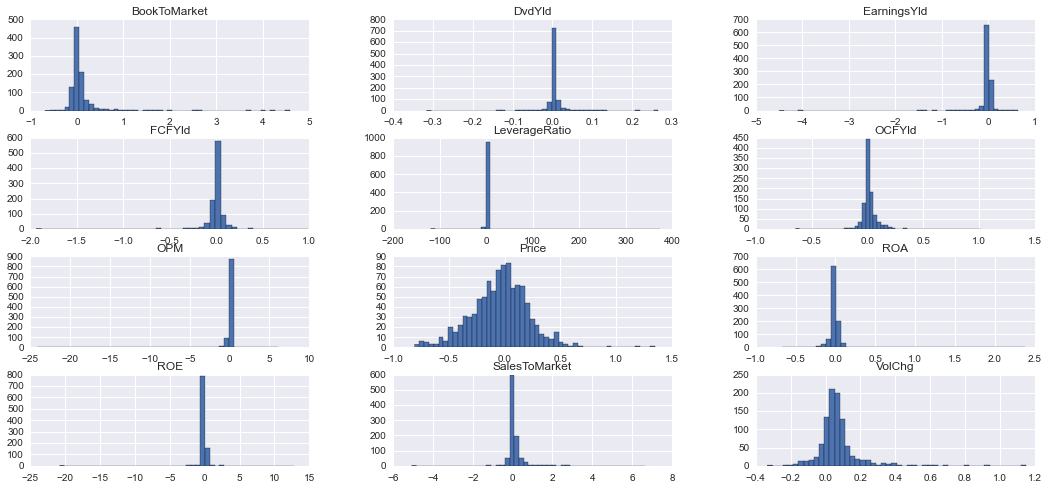

In [62]:
#Univariate analysis: Histogram of each x variable
df_chg.hist(bins=50,figsize=(18,8));

In [63]:
from sklearn.linear_model import Ridge
Xg = X.reset_index().drop('Ticker', axis=1)
yg = y.reset_index().drop('Ticker', axis=1)
data = pd.concat(([yg, Xg]), axis = 1)

Xg.head()

,Price,ROE,ROA,DvdYld,EarningsYld,BookToMarket,LeverageRatio,OCFYld,FCFYld,OPM,SalesToMarket,VolChg
0,0.200312,-0.163141,-0.058194,0.000000,0.000799,0.032122,1.145805,0.001173,0.003042,0.000263,-0.015151,0.16062
1,-0.374921,0.179127,0.072836,0.008668,0.152207,0.348018,0.135436,0.109048,0.073331,0.123356,0.626615,0.15587
2,-0.252472,-0.018257,-0.000565,0.015231,0.022975,0.101667,-0.377266,0.120065,0.105732,0.001117,0.145079,0.02064
3,-0.580460,0.101604,0.042983,0.000000,0.507692,2.539199,-0.045291,0.789593,0.036911,0.188759,1.851176,0.16210
4,-0.011971,-0.236505,-0.032412,0.008390,-0.032636,-0.015234,1.794512,0.017870,0.016647,-0.108261,0.050553,0.03474


In [64]:
#Summary of the y variable:
yg.describe()

,1m_return
count,986.000000
mean,-0.070637
std,0.098444
min,-0.596750
25%,-0.123652
50%,-0.059450
75%,-0.006600
max,0.250352


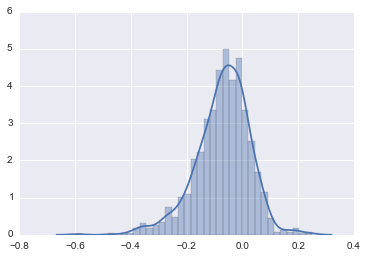

In [65]:
#Distribution of the y variable
sns.distplot(yg)

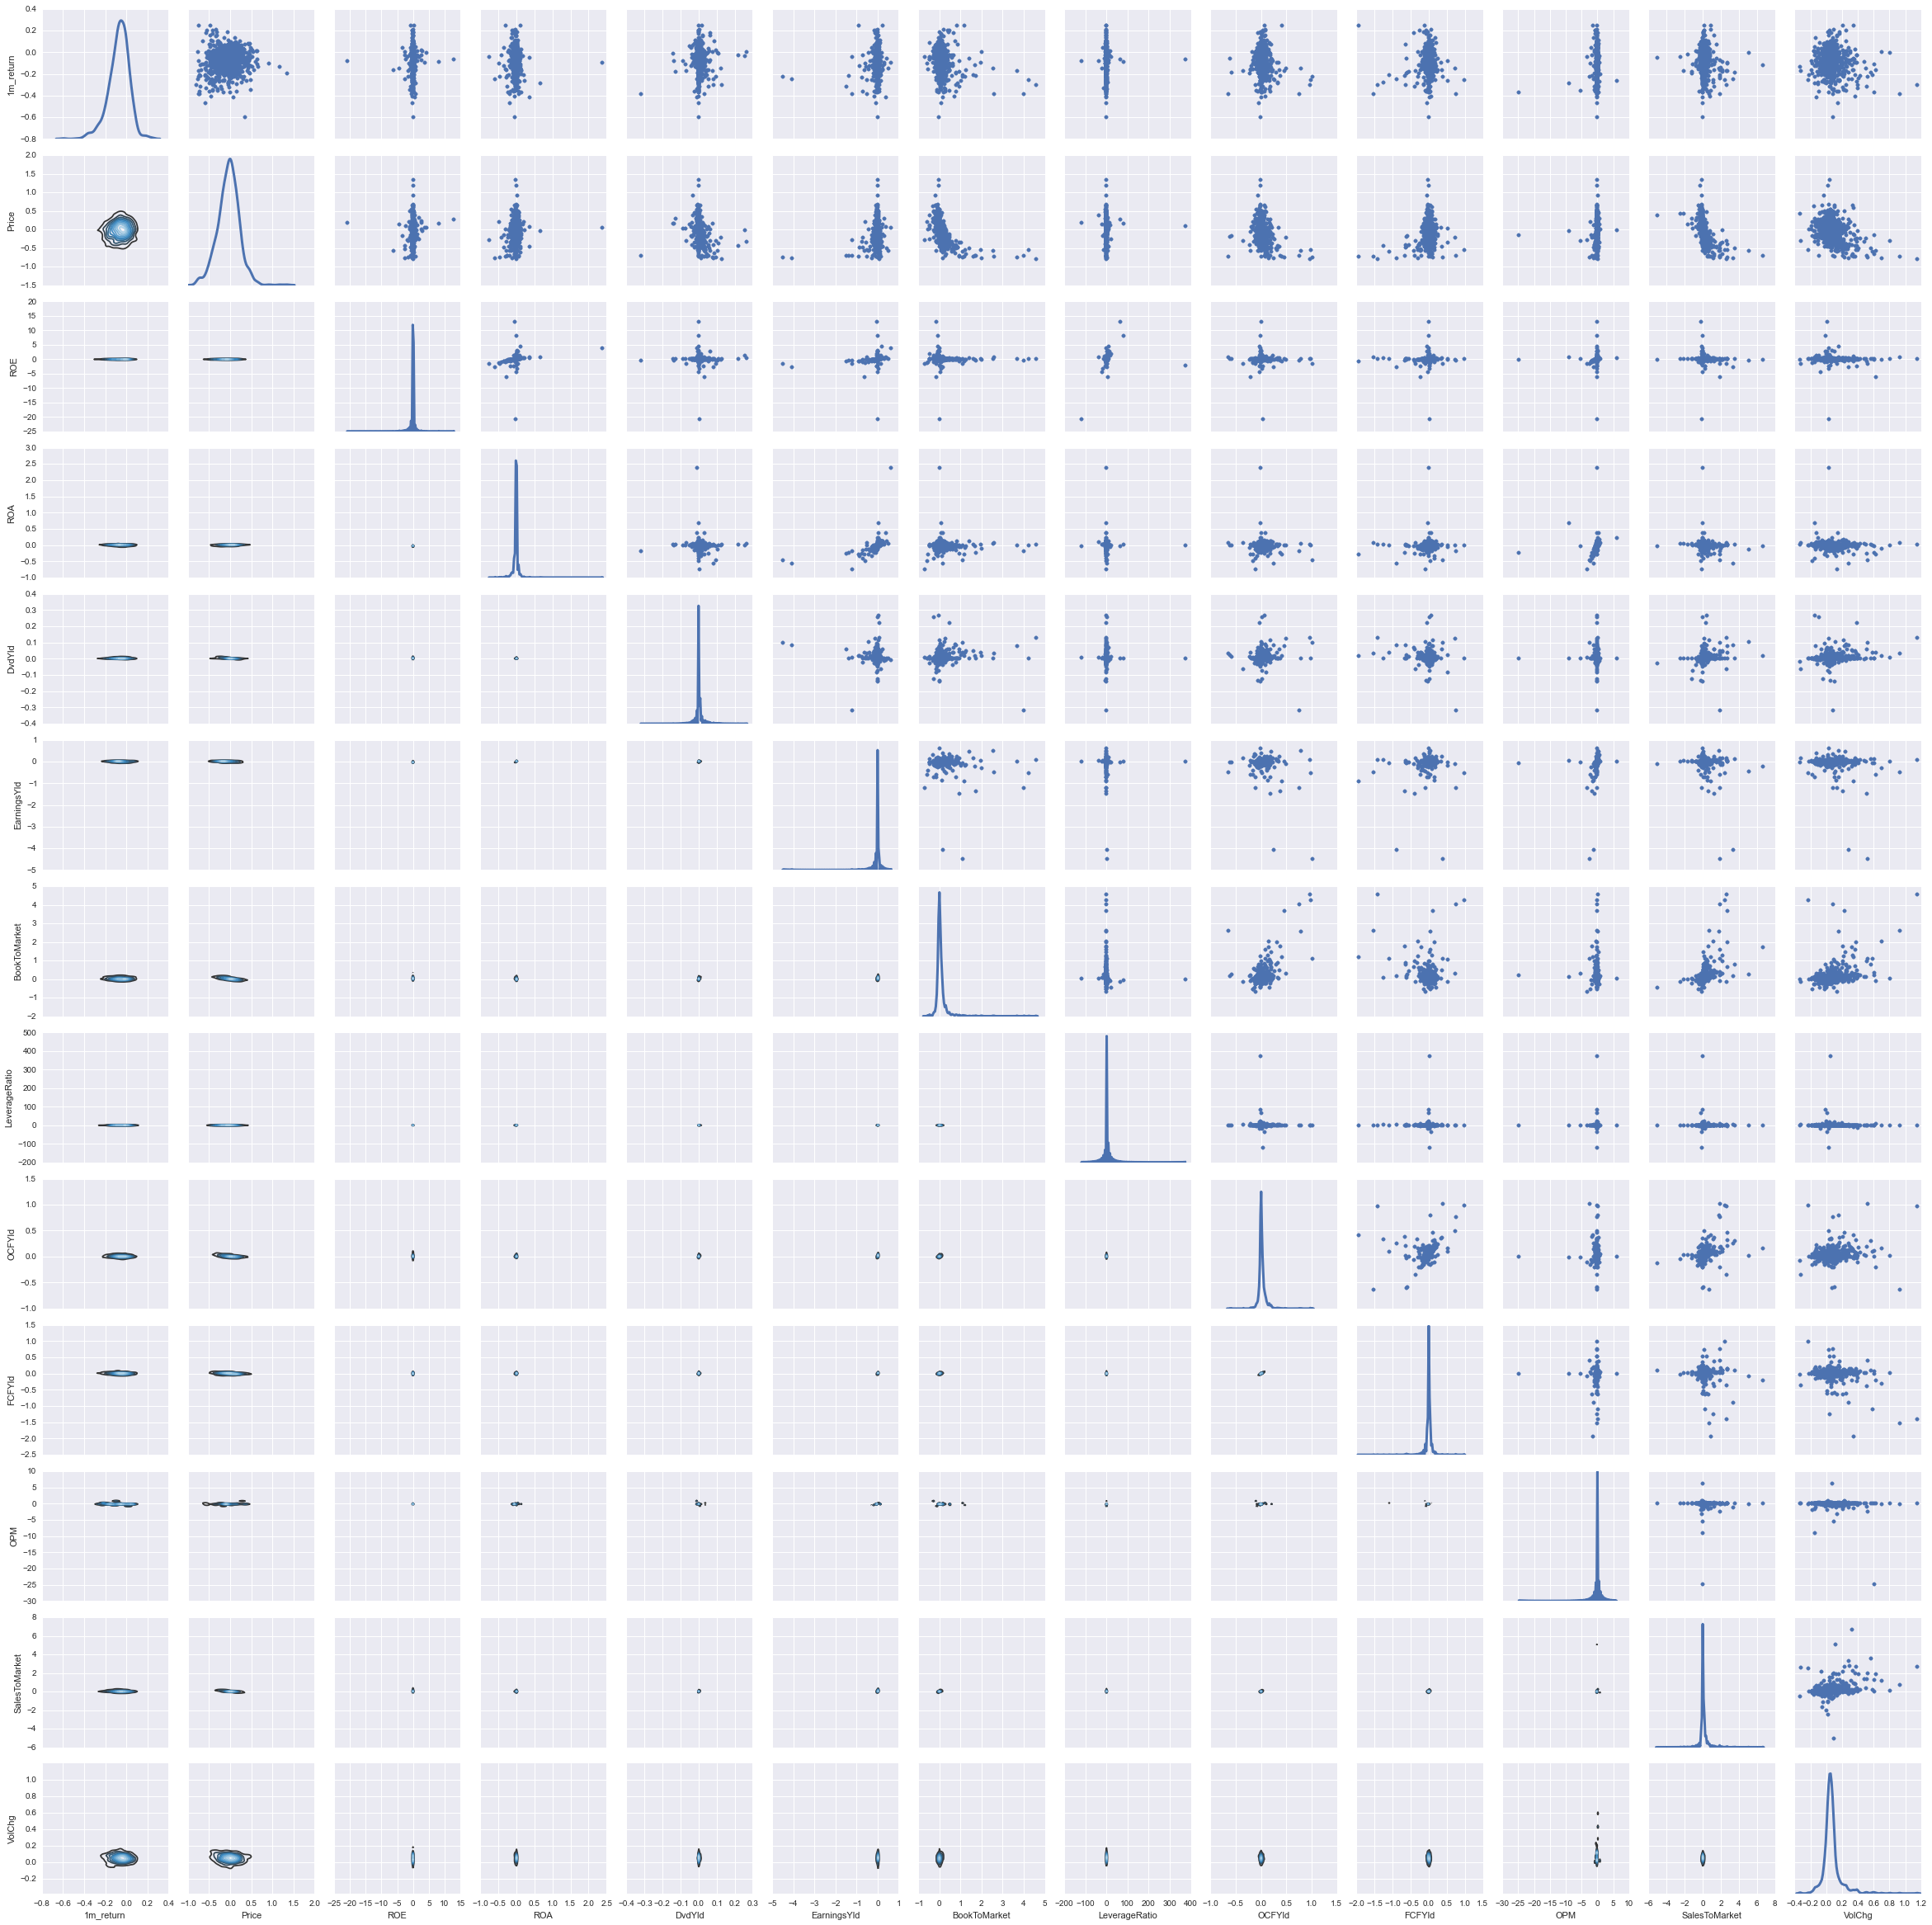

In [66]:
#Bivariate analysis
import matplotlib.pyplot as plt

g = sns.PairGrid(data, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

## Feature Selection
Now we compare three methods of feature selection to determine which features are more important to stock returns.
1. F test
2. P-value screen
3. Recursive feature elimination (RFE)

In [67]:
from sklearn import feature_selection as fs

def f_regression_feature_selection(input, response):    
# use this against your feature matrix to determine p-values for
# each feature (we care about the second array it returns).
    return fs.univariate_selection.f_regression(input, response)
# How many features do not meet the F test threshold?
sum(f_regression_feature_selection(X,y)[0] < 10)

5

In [68]:
# Which features do not meet the F test threshold?
select = f_regression_feature_selection(X,y)[0] < 10
X.columns[select]

Index([u'ROE', u'ROA', u'DvdYld', u'LeverageRatio', u'FCFYld'], dtype='object')

In [69]:
# How many features do not meet the p-value test?
sum(f_regression_feature_selection(X,y)[1] > 0.05)

5

In [70]:
#The F-test and the p-scores screen out the same five variables. Great!
select = (f_regression_feature_selection(X,y)[1] > 0.05)
X.columns[select]

Index([u'ROE', u'ROA', u'DvdYld', u'LeverageRatio', u'FCFYld'], dtype='object')

In [71]:
# difference between the ones available and the ones we wish to drop
select = pd.Index(X.columns).difference(pd.Index(X.columns[select]))

Xs = X[select]
# How many features do not meet the F test threshold?
sum(f_regression_feature_selection(Xs,y)[1] > 0.05)

0

In [72]:
# Sort the features based on their statistical significance 
ps = f_regression_feature_selection(Xs,y)[1]

p_score = zip(Xs.columns, ps)
ranked_p = sorted(p_score, key=lambda x:x[1])
p_features = [x[0] for x in ranked_p][:7]
ranked_p


[('BookToMarket', 6.2227557074145814e-11),
 ('VolChg', 2.2545344428697131e-06),
 ('SalesToMarket', 3.4456525219319327e-05),
 ('EarningsYld', 0.00027118443500545527),
 ('OPM', 0.00032877311439912334),
 ('OCFYld', 0.00043246020168429472),
 ('Price', 0.00057691754157330132)]

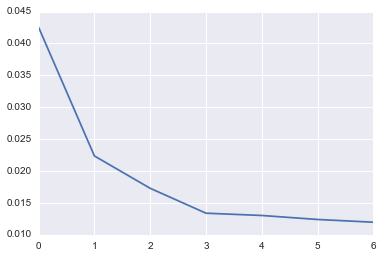

In [73]:
# Let's first build univariate models to see how well each individual features performs
scores = []
for feat, score in ranked_p:
    est = Ridge()
    X = [[x] for x in Xs[feat]]
    est.fit(X,y)
    scores.append(est.score(X,y))
# Drop of R^2 with strong to weakest features
plt.plot(range(len(scores)), scores)

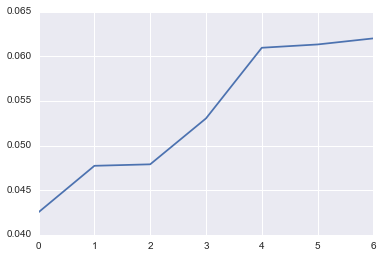

In [74]:
# Now let's build models which cumulatively look at how well combinations of features perform
scores = []
feats = []
for feat, score in ranked_p:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        X = [[x] for x in Xs[feat]]
    else:
        X = Xs[feats]
    est.fit(X, y)
    scores.append(est.score(X,y))
# Drop of R^2 with strong to weakest features
plt.plot(range(len(scores)), scores)
#Looks like the last two variables, the price momentum and operating cash flow yield, do not contribute much to the stock returns. Let's drop them.

In [76]:
handpicked_features = [ranked_p[x][0] for x in range(0,5)]
est = Ridge()

#R-squared when using 5 x variables.
X = Xs[handpicked_features]
print est.fit(X, y).score(X,y), handpicked_features

#R-squared when using 7 x variables.
X = Xs[p_features]
print est.fit(X, y).score(X,y), p_features

0.060950678046 ['BookToMarket', 'VolChg', 'SalesToMarket', 'EarningsYld', 'OPM']
0.0620000739793 ['BookToMarket', 'VolChg', 'SalesToMarket', 'EarningsYld', 'OPM', 'OCFYld', 'Price']


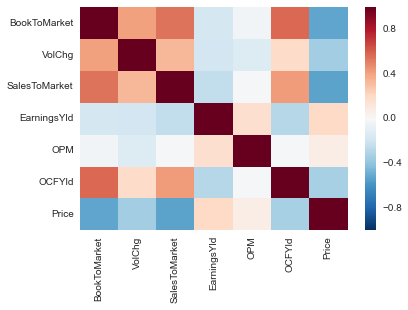

In [77]:
#Indeed, the OCF yield has a very high correlation with book to market, and the price momentum has a strong negative correlation with book to market and sales to market.
correlation = Xs[[x[0] for x in ranked_p][:7]]
sns.heatmap(correlation.corr())

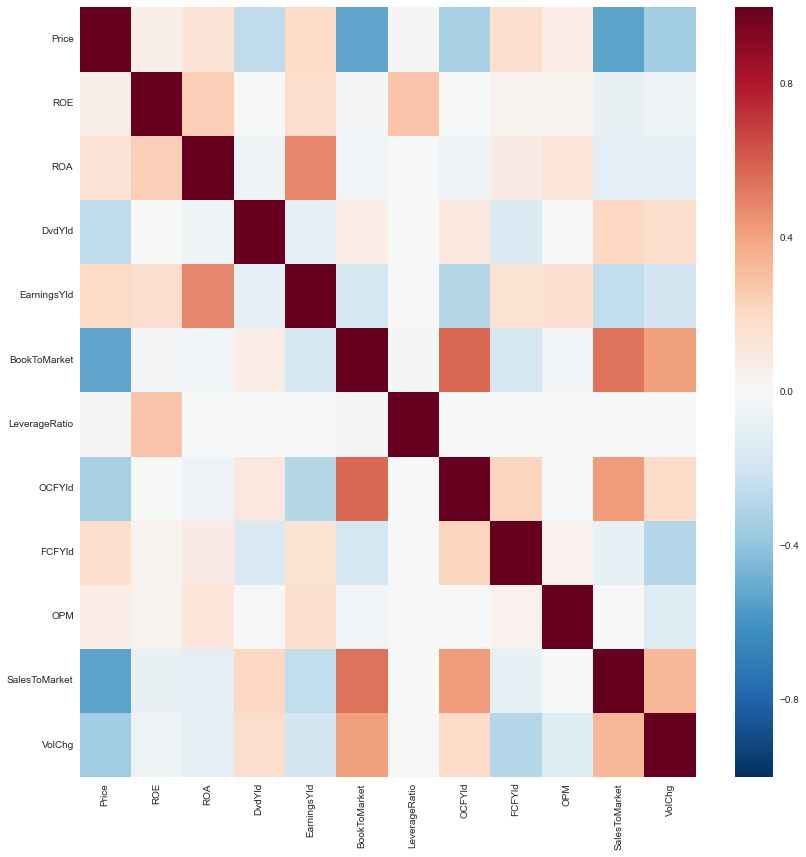

In [78]:
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_chg.corr())#, annot=False, sig_stars=False, diag_names=False, cmap=cmap, ax=ax)
f.tight_layout()
#Correlation matrix of the original 12 variables.

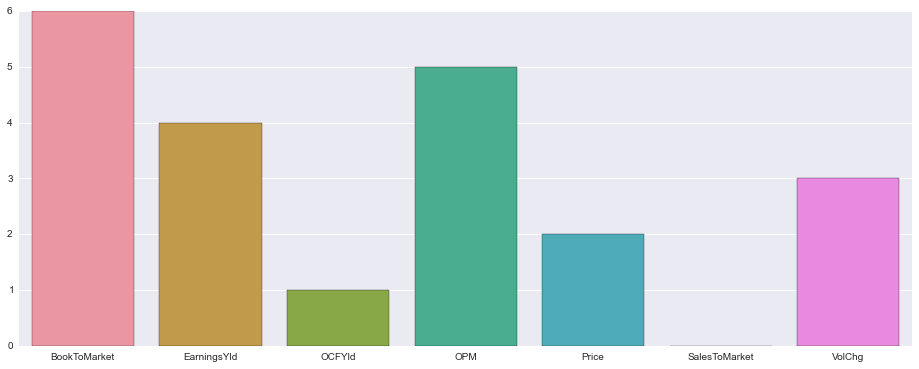

In [79]:
#Let's use the recursive feature elimination model
stand_Xs = (Xs - Xs.mean()) / Xs.std()
from sklearn.feature_selection import RFE

# Create the RFE object and rank each features
est = Ridge()
rfe = RFE(estimator=est, n_features_to_select=1, step=1)

rfe.fit(stand_Xs, y)
ranking = rfe.ranking_

scores = zip(Xs.columns,ranking)
scores = sorted(scores, key=lambda x:x[1])
# Features Importance 
plt.figure(figsize=(16, 6))
sns.barplot(Xs.columns, 7 - ranking);

In [80]:
#Evaluation: Summary of scores
rfe_features = [x[0] for x in scores][:4]
for feats in [handpicked_features, p_features, rfe_features]:
    est = Ridge()
    X = Xs[feats]
    print est.fit(X, y).score(X,y), feats
print est.fit(df_chg, y).score(df_chg,y), "[All 12 variables]"
#Looks like we can use just four variables: 'BookToMarket', 'OPM', 'EarningsYld' and 'VolChg'. 


0.060950678046 ['BookToMarket', 'VolChg', 'SalesToMarket', 'EarningsYld', 'OPM']
0.0620000739793 ['BookToMarket', 'VolChg', 'SalesToMarket', 'EarningsYld', 'OPM', 'OCFYld', 'Price']
0.0609262374583 ['BookToMarket', 'OPM', 'EarningsYld', 'VolChg']
0.0720477387502 [All 12 variables]


In [95]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
Xg = X.reset_index().drop('Ticker', axis=1)
yg = y.reset_index().drop('Ticker', axis=1)
data = pd.concat(([yg, Xg]), axis = 1)

# Make the model object
regr = linear_model.LinearRegression()
regr.fit(Xg,yg)
print "y intercept:", regr.intercept_
print "R squared:", regr.score(Xg, yg)
y_actual = yg
y_hat = regr.predict(Xg)

# Display our SSE:
print "SSE: {}".format(np.sum((y_actual - y_hat) ** 2))

# Scoring our model (closer to 1 is better!)
print "R^2: {}".format(regr.score(Xg, yg))

y intercept: [-0.06198836]
R squared: 0.0609448781427
SSE: 1m_return    8.964168
dtype: float64
R^2: 0.0609448781427


In [98]:
#OLS Regression Results
from statsmodels.formula.api import ols
results = ols('y ~ X', df_chg).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     15.92
Date:                Mon, 13 Jun 2016   Prob (F-statistic):           1.24e-12
Time:                        14:54:08   Log-Likelihood:                 918.23
No. Observations:                 986   AIC:                            -1826.
Df Residuals:                     981   BIC:                            -1802.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0620      0.004    -17.419      0.0

## Conclusions: When we evaluate U.S. stocks, it is the most important to look at the changes in Book to Market, Operating Profit Margin, Earnings Yield, and Price Volatility of each stock.

### Application: Let's apply this model in long/short equity investment. 

In [ ]:
# What happens if we use the RFE model to predict next month's stock returns and create a long/short equity portfolio based on those predictions?
# Let's rank the predicted returns and create a portfolio where we buy the top 5% return stocks and short sell the bottom 5% return stocks.
X = Xs[rfe_features]

pmodel = est.fit(X,y)
y_predict = pd.DataFrame(y)
#pd.Series(pmodel.predict(X)).rename("predicted_return")
temp_df = pd.DataFrame(pd.Series(pmodel.predict(X)).rename("predicted_return")).set_index(y.index)
y_predict = pd.concat([y_predict,temp_df], axis = 1)
y_predict['rank'] = y_predict.predicted_return.rank(ascending=False)
y_predict.ix[(y_predict['rank'] <= len(y_predict) * 0.05),'1m_return'].mean() - y_predict.ix[(y_predict['rank'] >= len(y_predict) * 0.95), '1m_return'].mean()
#5.4% monthly return is fantastic but of course there is a hindsight problem.

In [ ]:
#Let's use the January data to test again.
# Load the first dataset from 01/31/2015
df15_jan = pd.read_csv(DATA_DIR + '20150131stocks_v2.csv')
# Load the second dataset from 01/31/2016
df16_jan = pd.read_csv(DATA_DIR + '20160131stocks_v2.csv')
df15_jan.rename(columns=lambda x: x+'15',inplace=True)
df16_jan.rename(columns=lambda x: x+'16',inplace=True)
df_all_15_16_jan = pd.concat([df15_jan,df16_jan], axis = 1)
df_all_15_16_jan.rename(columns={'Ticker15': 'Ticker','Country15': 'Country', 'Name15':'Name','Sector15':'Sector'}, inplace=True)
# Return (column name, missing value count) for each of the columns in the dataframe
is_null = lambda col: sum(pd.isnull(df_all_15_16_jan[col]))
missing_values = [(col,is_null(col)) for col in df_all_15_16_jan if is_null(col)]
missing_values

In [ ]:
#Drop the rows without price data
df_all_15_16_jan = df_all_15_16_jan[df_all_15_16_jan['LastPrice15'].notnull()]
df_all_15_16_jan = df_all_15_16_jan[df_all_15_16_jan['LastPrice+1M15'].notnull()]
df_all_15_16_jan = df_all_15_16_jan[df_all_15_16_jan['LastPrice+1M16'].notnull()]
df_all_15_16_jan = df_all_15_16_jan[df_all_15_16_jan['LastPrice16'].notnull()]
#Drop the columns with too many missing values
df_all_15_16_jan.drop('TRAIL_12M_GROSS_MARGIN15', axis=1, inplace=True)
df_all_15_16_jan.drop('TRAIL_12M_ACCT_RCV_UNBILLED_REV15', axis=1, inplace=True)
df_all_15_16_jan.drop('TRAIL_12M_GROSS_MARGIN16', axis=1, inplace=True)
df_all_15_16_jan.drop('TRAIL_12M_ACCT_RCV_UNBILLED_REV16', axis=1, inplace=True)
df_all_15_16_jan.drop('TRAIL_12M_INT_EXP15', axis=1, inplace=True)
df_all_15_16_jan.drop('TRAIL_12M_INT_EXP16', axis=1, inplace=True)

df_all_15_16_jan = df_all_15_16_jan.fillna(0)


df_all_15_16_jan.loc[df_all_15_16_jan.TOTAL_EQUITY15<0, 'TOTAL_EQUITY15'] = df_all_15_16_jan.loc[df_all_15_16_jan.TOTAL_EQUITY15<0, 'CUR_MKT_CAP15'] * 0.1
df_all_15_16_jan.loc[df_all_15_16_jan.TOTAL_EQUITY16<0, 'TOTAL_EQUITY16'] = df_all_15_16_jan.loc[df_all_15_16_jan.TOTAL_EQUITY16<0, 'CUR_MKT_CAP16'] * 0.1




In [ ]:
df_all_15_16_jan = df_all_15_16_jan[(df_all_15_16_jan['TOTAL_EQUITY15']!=0) & (df_all_15_16_jan['TOTAL_EQUITY16']!=0)]

In [ ]:
df_2015_jan_ratios = pd.DataFrame()
df_2016_jan_ratios = pd.DataFrame()
df_2015_jan_ratios['Ticker'] = df_all_15_16_jan['Ticker']
df_2016_jan_ratios['Ticker'] = df_all_15_16_jan['Ticker']

df_2015_jan_ratios['Price'] = df_all_15_16_jan['LastPrice15']
df_2016_jan_ratios['Price'] = df_all_15_16_jan['LastPrice16']

df_2015_jan_ratios['ROE'] = df_all_15_16_jan['TRAIL_12M_EARN_FOR_COMMON15']/df_all_15_16_jan['TOTAL_EQUITY15']
df_2016_jan_ratios['ROE'] = df_all_15_16_jan['TRAIL_12M_EARN_FOR_COMMON16']/df_all_15_16_jan['TOTAL_EQUITY16']

df_2015_jan_ratios['ROA'] = df_all_15_16_jan['TRAIL_12M_EARN_FOR_COMMON15']/df_all_15_16_jan['BS_TOT_ASSET15']
df_2016_jan_ratios['ROA'] = df_all_15_16_jan['TRAIL_12M_EARN_FOR_COMMON16']/df_all_15_16_jan['BS_TOT_ASSET16']

df_2015_jan_ratios['DvdYld'] = -df_all_15_16_jan['T12M_DVDS_PAID15']/df_all_15_16_jan['CUR_MKT_CAP15']
df_2016_jan_ratios['DvdYld'] = -df_all_15_16_jan['T12M_DVDS_PAID16']/df_all_15_16_jan['CUR_MKT_CAP16']


df_2015_jan_ratios['EarningsYld'] = df_all_15_16_jan['TRAIL_12M_EARN_FOR_COMMON15']/df_all_15_16_jan['CUR_MKT_CAP15']
df_2016_jan_ratios['EarningsYld'] = df_all_15_16_jan['TRAIL_12M_EARN_FOR_COMMON16']/df_all_15_16_jan['CUR_MKT_CAP16']

df_2015_jan_ratios['BookToMarket'] = df_all_15_16_jan['TOTAL_EQUITY15']/df_all_15_16_jan['CUR_MKT_CAP15'] 
df_2016_jan_ratios['BookToMarket'] = df_all_15_16_jan['TOTAL_EQUITY16']/df_all_15_16_jan['CUR_MKT_CAP16'] 


df_2015_jan_ratios['LeverageRatio'] = df_all_15_16_jan['NET_DEBT15']/ df_all_15_16_jan['TOTAL_EQUITY15'] 
df_2016_jan_ratios['LeverageRatio'] = df_all_15_16_jan['NET_DEBT16']/ df_all_15_16_jan['TOTAL_EQUITY16'] 


df_2015_jan_ratios['OCFYld']=df_all_15_16_jan['TRAIL_12M_CASH_FROM_OPER15']/df_all_15_16_jan['CUR_MKT_CAP15'] 
df_2016_jan_ratios['OCFYld']=df_all_15_16_jan['TRAIL_12M_CASH_FROM_OPER16']/df_all_15_16_jan['CUR_MKT_CAP16'] 


df_2015_jan_ratios['FCFYld']=df_all_15_16_jan['TRAIL_12M_FREE_CASH_FLOW15']/df_all_15_16_jan['CUR_MKT_CAP15'] 
df_2016_jan_ratios['FCFYld']=df_all_15_16_jan['TRAIL_12M_FREE_CASH_FLOW16']/df_all_15_16_jan['CUR_MKT_CAP16'] 



df_2015_jan_ratios['OPM'] = df_all_15_16_jan['TRAIL_12M_OPER_MARGIN15'] /100 # converting to %
df_2016_jan_ratios['OPM'] = df_all_15_16_jan['TRAIL_12M_OPER_MARGIN16'] /100 # converting to %


df_2015_jan_ratios['SalesToMarket'] = df_all_15_16_jan['TRAIL_12M_NET_SALES15']/df_all_15_16_jan['CUR_MKT_CAP15']
df_2016_jan_ratios['SalesToMarket'] = df_all_15_16_jan['TRAIL_12M_NET_SALES16']/df_all_15_16_jan['CUR_MKT_CAP16']

df_2015_jan_ratios['VolChg'] = df_all_15_16_jan['VOLATILITY_90D15'] /100 # converting to %
df_2016_jan_ratios['VolChg'] = df_all_15_16_jan['VOLATILITY_90D16'] /100 # converting to %

df_2015_jan_ratios = df_2015_jan_ratios.set_index('Ticker')
df_2016_jan_ratios = df_2016_jan_ratios.set_index('Ticker')
df_all_15_16_jan = df_all_15_16_jan.set_index('Ticker')

In [ ]:
#Testing the model with a new dataset based on bloomberg data as of January 2016 to predict one-month returns in February 2016.
df_2015_jan_ratios.describe()

In [ ]:
df_chg_jan = pd.DataFrame()

df_chg_jan = df_2016_jan_ratios - df_2015_jan_ratios

df_chg_jan['Price'] = df_2016_jan_ratios['Price'] / df_2015_jan_ratios['Price'] - 1

y_jan = df_all_15_16_jan['LastPrice+1M16'] / df_all_15_16_jan['LastPrice16'] - 1
y_jan = y_jan.rename("1m_return")

In [ ]:
X_jan = df_chg_jan[rfe_features]

In [ ]:
#We have cleaned the Jan 2016 YoY database. Now using the p value model we created before and apply to the Jan 31 2016 sets of stocks for a long short portfolio and see the return for Feb 28 2016 over Jan 31 2016
y_predict_jan = pd.DataFrame(y_jan)
temp_df = pd.DataFrame(pd.Series(pmodel.predict(X_jan)).rename("predicted_return")).set_index(y_predict_jan.index)

In [ ]:
y_predict_jan = pd.concat([y_predict_jan,temp_df], axis = 1)
y_predict_jan['rank'] = y_predict_jan.predicted_return.rank(ascending=False)
y_predict_jan.ix[(y_predict_jan['rank'] <= len(y_predict_jan) * 0.05),'1m_return'].mean() - y_predict_jan.ix[(y_predict_jan['rank'] >= len(y_predict_jan) * 0.95), '1m_return'].mean()

#2.5% return in one month is pretty good! February 2016 was also a month when many fund managers lost money.

## Assumptions of linear regression
1. Variables are normally distributed.
2. Variables are measured without error reliably.
3. Homoscedasticity: Variance of errors is the same across all levels of the independent variable.
4. The independent variables are not correlated.
5. Independence of error terms.
6. Assume a linear relationship between the independent and dependent variables.

In [ ]:
#From the pair plot, the variables look normally distributed, and the variables look fairly independent.
sns.pairplot(df_chg[rfe_features])

## Evaluation of the model's strengths and weaknesses
Strengths:
- Provides an objective way to analyze the relationships between stock returns and the fundamental and technical variables.
- Can be rerun with datasets from other periods to check the model's validity.
- The model can be implemented in reality for long/short equity investing with monthly rebalancing.

Weaknesses:
- The x variables only explain a small part of the stock returns. A large part remains unexplained.
- The x variables are not completely uncorrelated.
- The relationship between the dependent variables and the stock returns may change over time.
- Daily returns of the portfolio during each month are not calculated.
- There is a reasonably long time lag between when the data is published and when the trades are executed.

In [ ]:
jupyter nbconvert estimation_project_slides3.ipynb --to slides --reveal-prefix https://cdn.jsdelivr.net/reveal.js/2.6.2/